# Base Models

In [98]:
import sys
sys.path.append('../src/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

import arviz as az

from utils.data_utils import destandardize_area, destandardize_price, load_data
from utils.plot_utils import draw_model_plot, set_plot_defaults

In [3]:
d, _, _ = load_data()
target = "price_s"

In [4]:
d.drop(columns=["lat", "lng"]).head()

,ags,zip,price,price_s,log_price,log_price_s,sqm_price,log_sqm_price,log_sqm_price_s,living_space,living_space_s,sale_year,sale_month,const_year,const_year_s,objecttype,housetype,usage,interior_qual
3,11000000001000000094,12489,180000.0,1.800,12.100712,-0.814839,2246.069379,7.716937,-1.009445,80.14,-0.276690,2018,8,1936.0,-1.210219,flat,NaN,rent_out,normal
4,11000000001000000094,12489,87000.0,0.870,11.373663,-2.045434,1740.000000,7.461640,-1.700113,50.00,-0.671528,2017,7,1910.0,-1.913696,flat,NaN,rent_out,NaN
6,11000000001000000140,12489,101200.0,1.012,11.524854,-1.789530,3066.666667,8.028346,-0.166971,33.00,-0.894229,2016,4,2016.0,0.954326,flat,NaN,rent_out,NaN
9,11000000001000000140,12489,148400.0,1.484,11.907667,-1.141586,3420.142890,8.137438,0.128159,43.39,-0.758119,2017,1,2017.0,0.981383,flat,NaN,rent_out,sophisticated
10,11000000001000000140,12489,261200.0,2.612,12.473042,-0.184638,3374.677003,8.124055,0.091954,77.40,-0.312584,2016,6,2016.0,0.954326,flat,NaN,rent_out,sophisticated


In [5]:
d.shape

(8014, 21)

## Intercept only model

$$\begin{align*}
price &\sim \text{Normal}(\mu, \sigma)\\
\mu &\sim \text{Normal}(0, 10)\\
\sigma &\sim \text{HalfCauchy}(10)
\end{align*}$$

In [37]:
with pm.Model() as intercept_normal:
    mu = pm.Normal("mu", mu=0, sd=10)
    sigma = pm.HalfNormal("sigma", sd=10)
    
    y = pm.Normal("y", mu=mu, sd=sigma, observed = d[target])
    
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1277.22draws/s]


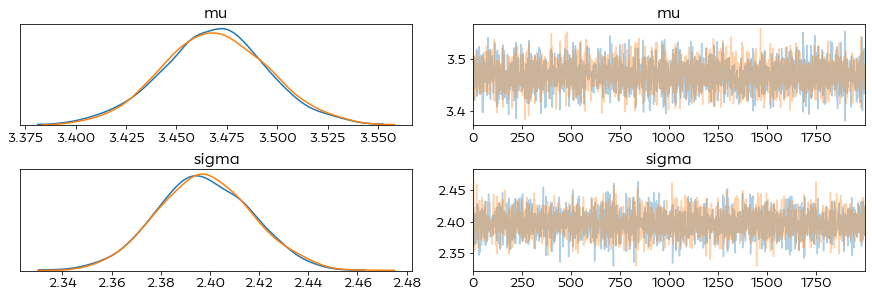

In [99]:
az.plot_trace(trace, coords={"chain":[0,1]})
plt.show()

In [9]:
with pm.Model() as intercept_student:
    mu = pm.Normal("mu", mu=0, sd=20)
    sigma = pm.HalfCauchy("sigma", 10)
    nu = pm.Gamma("nu", alpha=2, beta=0.1)
    
    y = pm.StudentT("y", mu=mu, sd=sigma, nu=nu, observed=d[target])
    
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [nu, sigma, mu]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:27<00:00, 442.08draws/s]


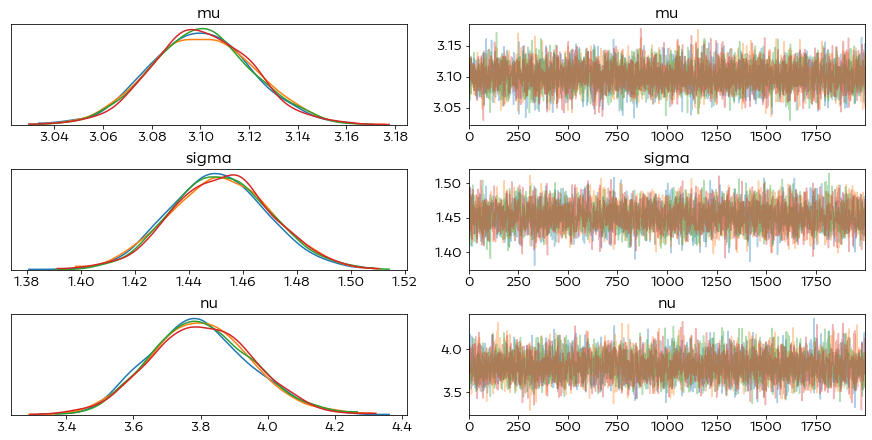

In [10]:
az.plot_trace(trace)
plt.show()

## Linear base model

$$\begin{align*}
price &\sim \text{Normal}(\mu, \sigma)\\
\mu &= \alpha + \beta \;\text{living_space}\\
\alpha &\sim \text{Normal}(0, 10) \\
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{HalfCauchy}(10)
\end{align*}$$

In [11]:
with pm.Model() as lin_normal:
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=1)
    mu = alpha + beta*d["living_space_s"]
    
    sigma = pm.HalfCauchy("sigma", 5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:10<00:00, 1120.91draws/s]


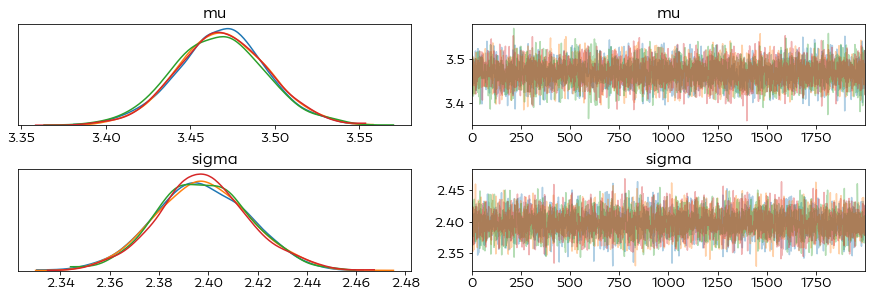

In [39]:
az.plot_trace(trace)
plt.show()

In [13]:
with pm.Model() as lin_student:
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=1)
    mu = alpha + beta*d["living_space_s"]
    
    sigma = pm.HalfCauchy("sigma", 5)
    nu = pm.Gamma("nu", alpha=2, beta=0.1)
    y = pm.StudentT("y", nu=nu, mu=mu, sd=sigma, observed=d[target])
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    
    prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [nu, sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:26<00:00, 450.11draws/s]


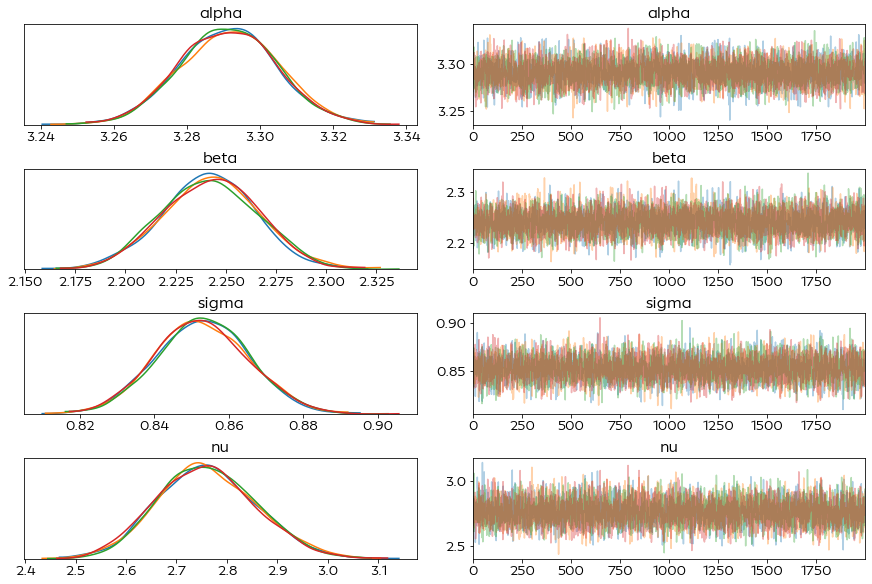

In [14]:
az.plot_trace(trace)
plt.show()

# Prior Predictive Checks

## Flat priors
Idea: have uninformative priors and thus be more objective/less subjective

In [43]:
with pm.Model() as flat_prior:
    alpha = pm.Normal("alpha", mu=0, sd=1000)
    beta = pm.Normal("beta", mu=0, sd=1000)
    mu = alpha + beta*d["living_space_s"]
    
    sigma = pm.Exponential("sigma", 1/5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    
    flat_prior = pm.sample_prior_predictive()

In [44]:
with pm.Model() as less_flat_prior:
    alpha = pm.Normal("alpha", mu=0, sd=100)
    beta = pm.Normal("beta", mu=0, sd=100)
    mu = alpha + beta*d["living_space_s"]
    
    sigma = pm.Exponential("sigma", 1/5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    
    less_flat_prior = pm.sample_prior_predictive()

In [45]:
flat_data = az.from_pymc3( prior = flat_prior )
less_flat_data = az.from_pymc3( prior = less_flat_prior )

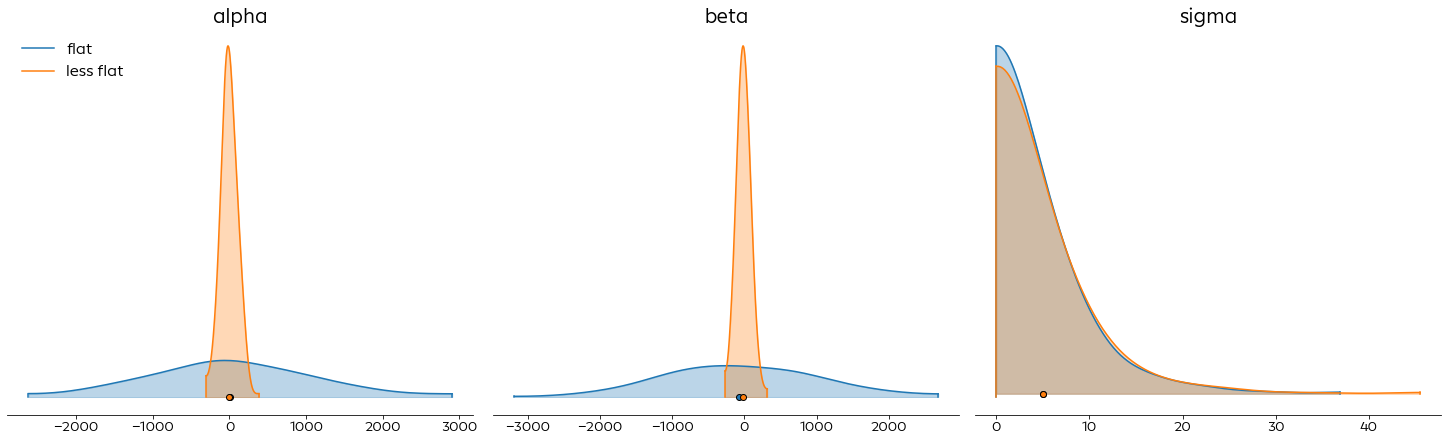

In [88]:
ax = az.plot_density([flat_data, less_flat_data], group="prior",
                data_labels = ["flat", "less flat"],
               var_names = ["alpha", "beta", "sigma"],
               shade=0.3, bw=8, figsize=(20,6), credible_interval=1)
ax[0].legend(frameon=False, prop={'size': 16}, markerscale=3., loc="upper left")
ax[0].set_title("alpha", fontdict={'fontsize': 20})
ax[1].set_title("beta", fontdict={'fontsize': 20})
ax[2].set_title("sigma", fontdict={'fontsize': 20})
plt.show()

In [19]:
area_s = np.linspace(start=-1.5, stop=3, num=50)

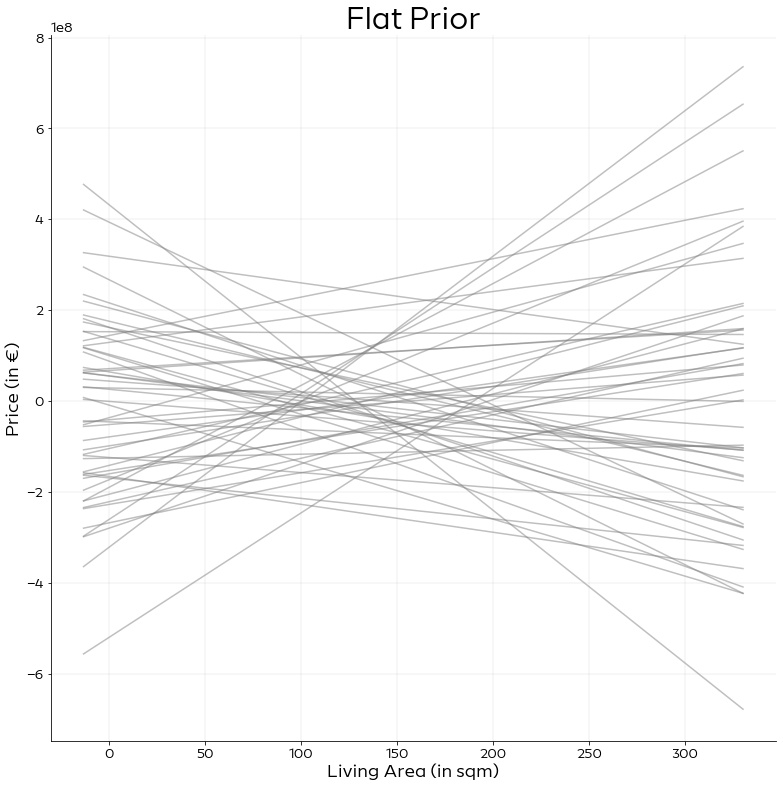

In [95]:
fig, ax = draw_model_plot(flat_prior, title="Flat Prior")
plt.show()

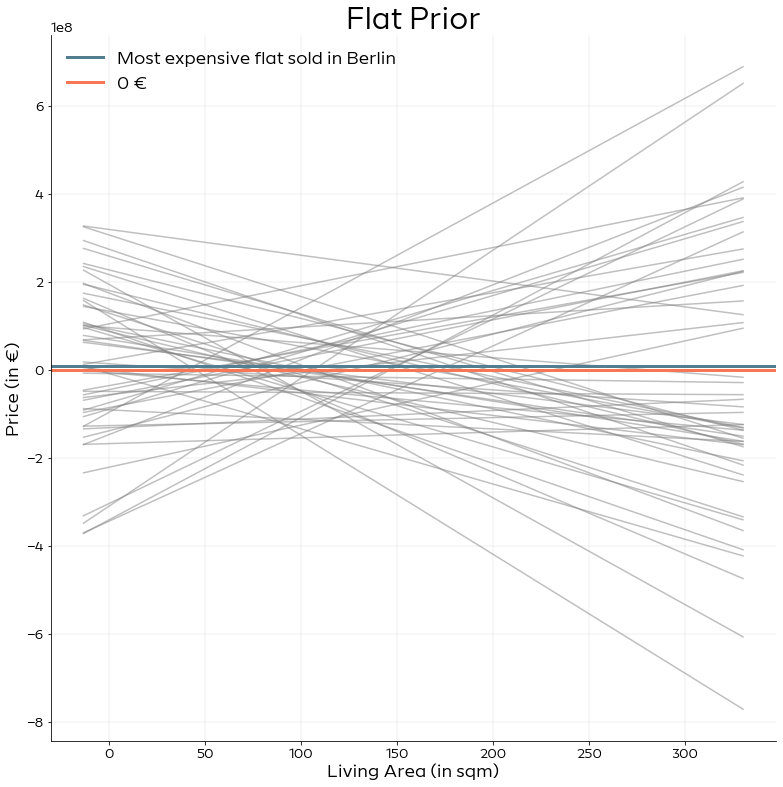

In [96]:
fig, ax = draw_model_plot(flat_prior, title="Flat Prior")
ax.axhline(y=8.5e6, c="#537d91", label="Most expensive flat sold in Berlin", lw=3)
ax.axhline(y=0, c="#f77754", label="0 €", lw=3)
ax.legend(frameon=False)
plt.show()

## Weakly informative prior

On recommendations what prior is recommended for the different parameters including what are good default parameter values, check [Prior recommendation by Stan team](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

In [61]:
with pm.Model() as weakly_inf_prior:
    alpha = pm.Normal("alpha", mu=0, sd=20)
    beta = pm.Normal("beta", mu=0, sd=5)
    mu = alpha + beta*d["living_space_s"]
    
    sigma = pm.Exponential("sigma", lam = 1/2.5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    
    weakly_inf_prior = pm.sample_prior_predictive()

In [62]:
weakly_inf_data = az.from_pymc3(prior=weakly_inf_prior)

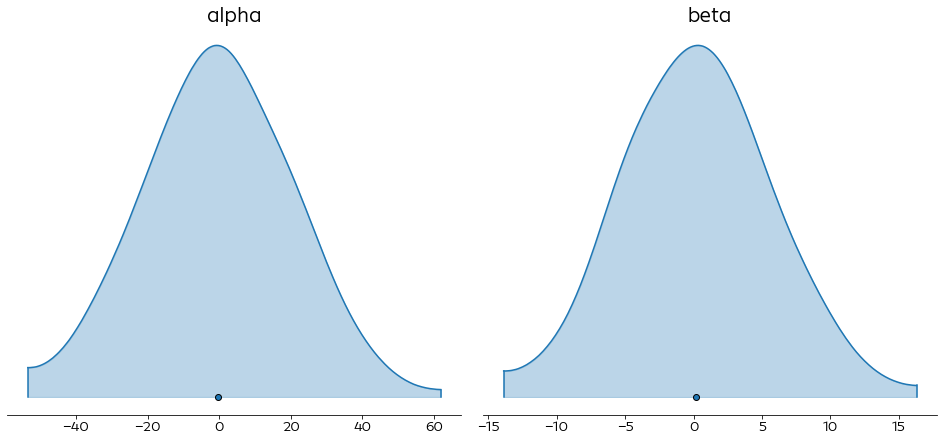

In [91]:
ax = az.plot_density(weakly_inf_data, group="prior",
                data_labels = ["weakly informative prior"],
               var_names = ["alpha", "beta"],
               shade=0.3, bw=8, figsize=(13,6), credible_interval=1)
ax[0].set_title("alpha", fontdict={'fontsize': 20})
ax[1].set_title("beta", fontdict={'fontsize': 20})
plt.show()

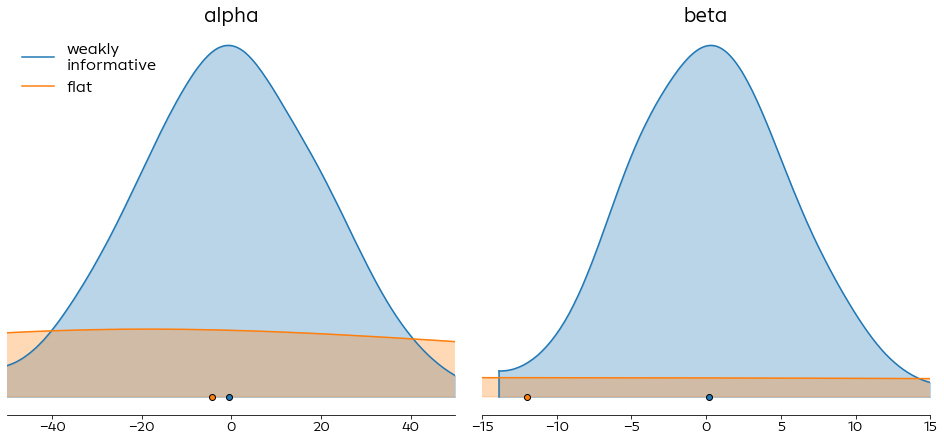

In [92]:
axes = az.plot_density([weakly_inf_data, less_flat_data], group="prior",
                data_labels = ["weakly\ninformative", "flat"],
               var_names = ["alpha", "beta"],
               shade=0.3, bw=8, figsize=(13,6), credible_interval=1)
axes[0].set_xlim(-50, 50)
axes[1].set_xlim(-15, 15)
axes[0].legend(frameon=False, prop={'size': 16}, markerscale=3., loc="upper left")
axes[0].set_title("alpha", fontdict={'fontsize': 20})
axes[1].set_title("beta", fontdict={'fontsize': 20})
plt.show()

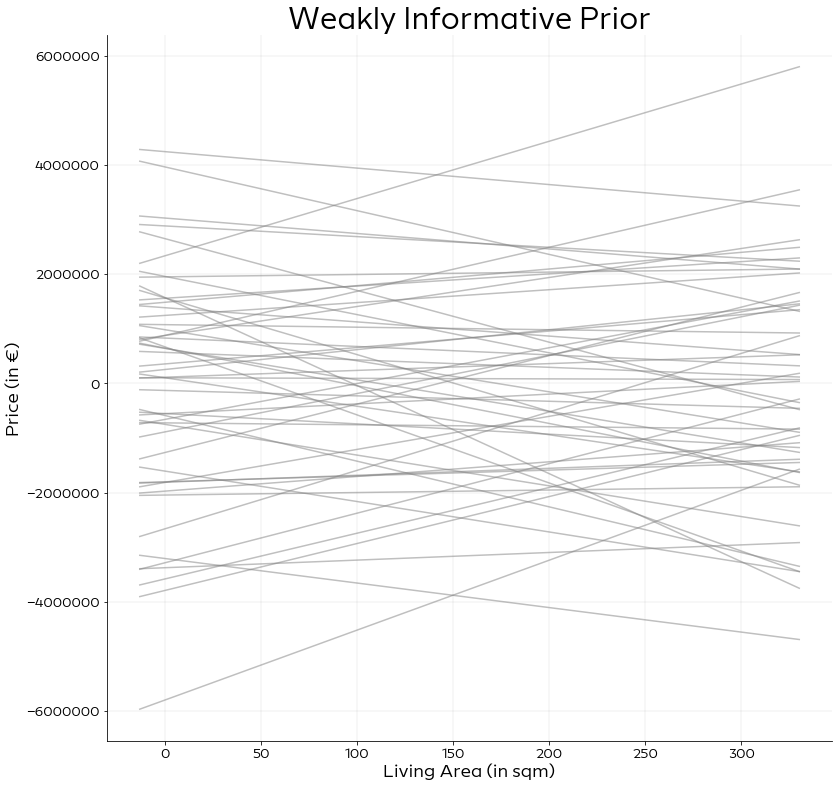

In [94]:
fig, ax = draw_model_plot(weakly_inf_prior, title="Weakly Informative Prior")
plt.show()

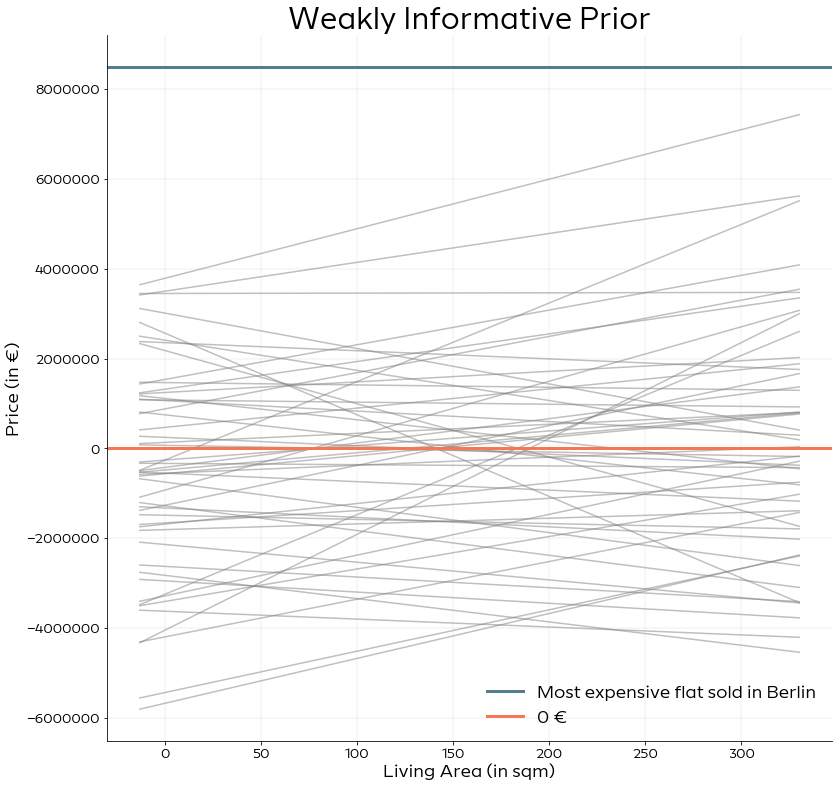

In [93]:
fig, ax = draw_model_plot(weakly_inf_prior, title="Weakly Informative Prior")
ax.axhline(y=8.5e6, c="#537d91", label="Most expensive flat sold in Berlin", lw=3)
ax.axhline(y=0, c="#f77754", label="0 €", lw=3)
ax.legend(frameon=False)
plt.show()

In [26]:
with pm.Model() as inf_prior:
    alpha = pm.Normal("alpha", mu=3, sd=2.5)
    beta = pm.Normal("beta", mu=1, sd=2.5)
    mu = alpha + beta*d["living_space_s"]
    
    sigma = pm.Exponential("sigma", lam = 1/2.5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=d[target])
    
    inf_prior = pm.sample_prior_predictive()

In [27]:
inf_data = az.from_pymc3(prior=inf_prior)

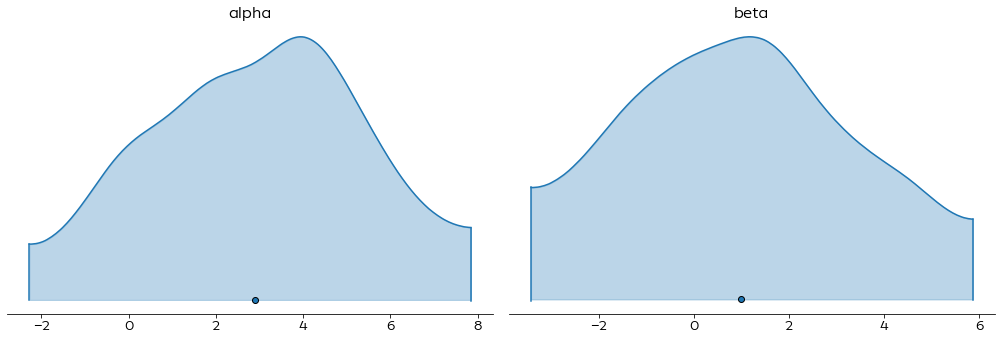

In [28]:
az.plot_density(inf_data, group="prior",
                data_labels = ["informative prior"],
               var_names = ["alpha", "beta"],
               shade=0.3, bw=8, figsize=(13,6), credible_interval=1)
plt.show()

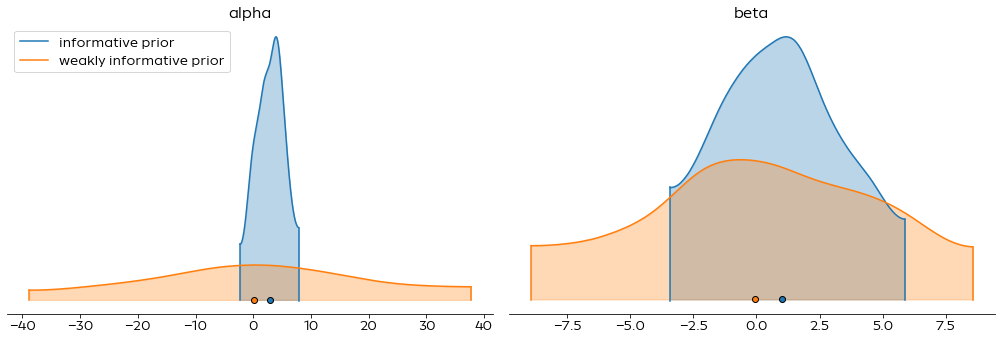

In [29]:
az.plot_density([inf_data, weakly_inf_data], group="prior",
                data_labels = ["informative prior", "weakly informative prior"],
               var_names = ["alpha", "beta"],
               shade=0.3, bw=8, figsize=(13,6), credible_interval=1)
plt.show()

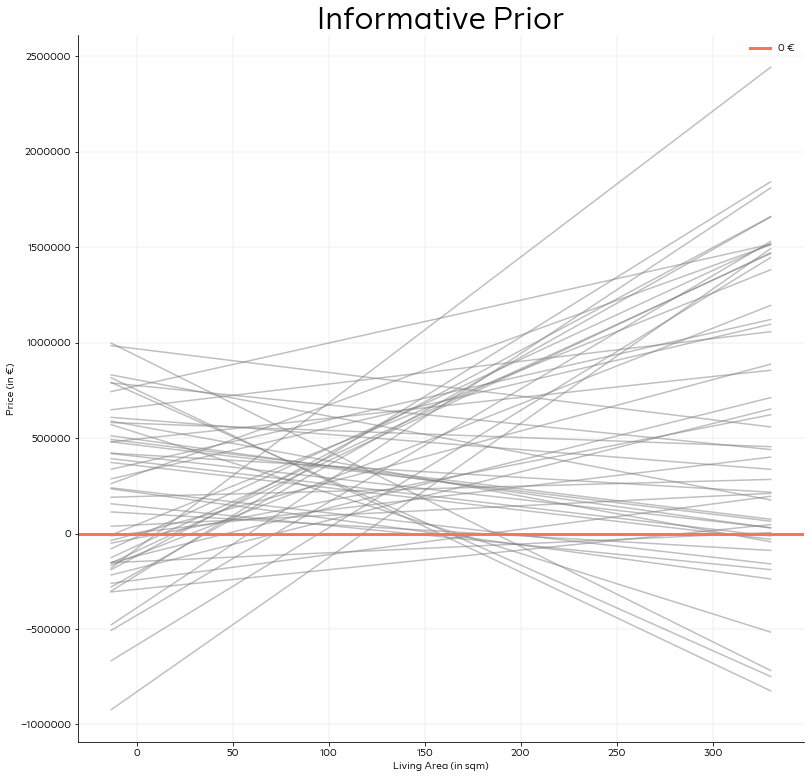

In [30]:
fig, ax = draw_model_plot(inf_prior, title="Informative Prior")
ax.axhline(y=0, c="#f77754", label="0 €", lw=3)
ax.legend(frameon=False)
plt.show()